In [198]:
import requests
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

user_name  = "WalvinDesu"
time_control = "Bullet"
#The method of loading data, options are API, FILE or BOTH
data_source = "BOTH"
#If loading using only the API, the following variables control how far to go back
year, month, day = 2023, 4, 10
#If using the FILE or BOTH options for data_source, store the file in the data folder and add its name below
file_name = "lichess_WalvinDesu_2023-04-07.pgn"


## Importing Lichess data into Pandas

In [199]:
def API_Load(user_name, year, month, day, hour=0, minute=0, second=0):
    """
    Imports chess data via the Lichess API and returns a list of games
    """
    start_date = datetime.datetime(year, month, day, hour, minute, second, tzinfo=pytz.UTC).timestamp()
    start_date = str(int(start_date*1000))
    x = requests.get(f"http://lichess.org/api/games/user/{user_name}?since={start_date}")
    #x = requests.get(f"http://lichess.org/api/games/user/{user_name}")
    chess_data = x.content.decode("utf-8")
    #Read the data as a list, dropping the final empty row    
    chess_data = chess_data.split("\n\n\n")[:-1]
    return chess_data

def File_Load(file_name):
    """
    Imports chess data via a saved file in the data folder and returns a list of games
    """
    chess_data = open("../data/" + file_name).read()
    #Read the data as a list, dropping the final empty row    
    chess_data = chess_data.split("\n\n\n")[:-1]
    return chess_data

def Up_To_Date_File_Load(user_name, file_name):
    """
    Imports chess data via a saved file in the data folder, updating it via the Lichess API
    and returning a list of games
    """
    chess_data = File_Load(file_name)
    last_game = line2dict(chess_data[0])
    last_dt = [int(_) for _ in (last_game["UTCDate"].replace(".",":") + ":" + last_game["UTCTime"]).split(":")]
    api_data = API_Load(user_name, year = last_dt[0], month = last_dt[1], day = last_dt[2], hour= last_dt[3], minute= last_dt[4], second = last_dt[5])
    return api_data[1:] + chess_data
  

def line2dict(line):
    """
    Parses each element of the list of imported data into a Dictionary
    """
    data, game  = line.split("\n\n")
    data = data.replace("[","").replace("]","").replace('"', "")
    datadict = {x[0]:x[1] for l in data.split("\n")[:-1] for x in [l.split(" ",1)]}
    datadict["PGN"] = game
    return datadict

if data_source.upper() == "API":
    chess_data = API_Load(user_name, year, month, day)
elif data_source.upper() == "FILE":
    chess_data = File_Load(file_name)
elif data_source.upper() == "BOTH":
    chess_data = Up_To_Date_File_Load(user_name, file_name)



## Modify the DataFrame to the perspective of the User

In [200]:
df = pd.DataFrame([line2dict(i) for i in chess_data])
#Process DataFrame
df = df[df["Event"].str.contains(time_control)]

df = df.set_index(pd.to_datetime(df["UTCDate"] + df["UTCTime"], format = "%Y.%m.%d%H:%M:%S"))
df = df.drop(["Date", "UTCDate", "UTCTime"], axis = 1)

df["UserColour"]     = np.where(df["White"] == user_name, "White", "Black")
df["OppName"]        = np.where(df["White"] == user_name, df["Black"], df["White"])
df["UserElo"]        = np.where(df["White"] == user_name, df["WhiteElo"], df["BlackElo"])
df["OppElo"]         = np.where(df["White"] == user_name, df["BlackElo"], df["WhiteElo"])
df["UserRatingDiff"] = np.where(df["White"] == user_name, df["WhiteRatingDiff"], df["BlackRatingDiff"])
df["OppRatingDiff"]  = np.where(df["White"] == user_name, df["BlackRatingDiff"], df["WhiteRatingDiff"])
df["WDL"]            = np.where(df["Result"] == "1/2-1/2", "D", 
                             np.where(((df["White"] == user_name) & (df["Result"] == "1-0")) | ((df["Black"] == user_name) & (df["Result"] == "0-1")), "W", "L"))
df = df.drop(["White", "Black", "WhiteElo", "BlackElo", "WhiteRatingDiff", "BlackRatingDiff", "Result", "FEN"], axis = 1)
#Convert ELO to float, removing provisional ELO ratings
df = df[(df["UserElo"].str[-1] != "?") & (df["OppElo"].str[-1] != "?")]
df["UserElo"] = df["UserElo"].astype(float)
df["OppElo"] = df["OppElo"].astype(float)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11221 entries, 2023-04-12 02:10:57 to 2019-06-07 22:12:04
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Event           11221 non-null  object 
 1   Site            11221 non-null  object 
 2   Variant         11221 non-null  object 
 3   TimeControl     11221 non-null  object 
 4   ECO             11221 non-null  object 
 5   PGN             11221 non-null  object 
 6   Termination     0 non-null      object 
 7   UserColour      11221 non-null  object 
 8   OppName         11221 non-null  object 
 9   UserElo         11221 non-null  float64
 10  OppElo          11221 non-null  float64
 11  UserRatingDiff  11213 non-null  object 
 12  OppRatingDiff   11213 non-null  object 
 13  WDL             11221 non-null  object 
dtypes: float64(2), object(12)
memory usage: 1.3+ MB


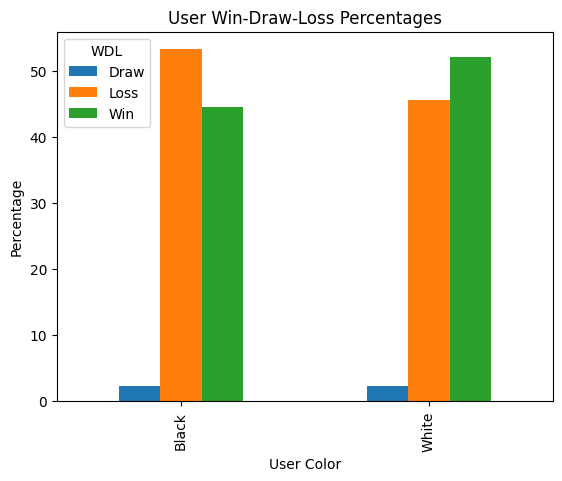

In [201]:
#Grouped bar chart for wins losses draws as white and black
wdl_pivot = pd.pivot_table(df, index="UserColour", columns="WDL", aggfunc="size")
wdl_pivot = wdl_pivot.div(wdl_pivot.sum(axis=1), axis =0)*100

fig, ax = plt.subplots()
wdl_pivot.plot(kind="bar", ax=ax)
ax.set_xlabel("User Color")
ax.set_ylabel("Percentage")
ax.set_title("User Win-Draw-Loss Percentages")
ax.legend(title="WDL", labels = ["Draw","Loss", "Win"])
plt.show()

In [202]:
#Create daily statistics Dataframe
daily_user_data = df["UserElo"].resample("D", offset="6H").ohlc()
#Forward fill missing values using the close value of the last non-missing day
daily_user_data['close'].ffill(inplace=True)
daily_user_data.fillna({'high': daily_user_data['close'], 
                        'low': daily_user_data['close'], 
                        'open': daily_user_data['close']}, inplace=True)
#Introduce columns for other daily statistics
daily_user_data["NumGames"]  = df["UserElo"].resample("D", offset="6H").count()
daily_user_data["WinCount"]  = df[df["WDL"]=="W"]["UserElo"].resample("D", offset="6H").count()
daily_user_data["LossCount"] = df[df["WDL"]=="L"]["UserElo"].resample("D", offset="6H").count()
daily_user_data["DrawCount"] = df[df["WDL"]=="D"]["UserElo"].resample("D", offset="6H").count()
daily_user_data[["NumGames","WinCount","LossCount","DrawCount"]] = daily_user_data[["NumGames","WinCount","LossCount","DrawCount"]].fillna(0).astype(int)

daily_user_data


,open,high,low,close,NumGames,WinCount,LossCount,DrawCount
2019-06-07 06:00:00,1500.0,1500.0,981.0,1078.0,8,0,8,0
2019-06-08 06:00:00,1078.0,1078.0,1078.0,1078.0,0,0,0,0
2019-06-09 06:00:00,1078.0,1078.0,1078.0,1078.0,0,0,0,0
2019-06-10 06:00:00,1078.0,1078.0,1078.0,1078.0,0,0,0,0
2019-06-11 06:00:00,1078.0,1078.0,1078.0,1078.0,0,0,0,0
...,...,...,...,...,...,...,...,...
2023-04-07 06:00:00,1479.0,1488.0,1435.0,1451.0,29,14,15,0
2023-04-08 06:00:00,1455.0,1485.0,1441.0,1478.0,28,15,11,2
2023-04-09 06:00:00,1484.0,1491.0,1446.0,1468.0,29,8,20,1
2023-04-10 06:00:00,1464.0,1472.0,1434.0,1435.0,34,15,19,0


<Axes: >

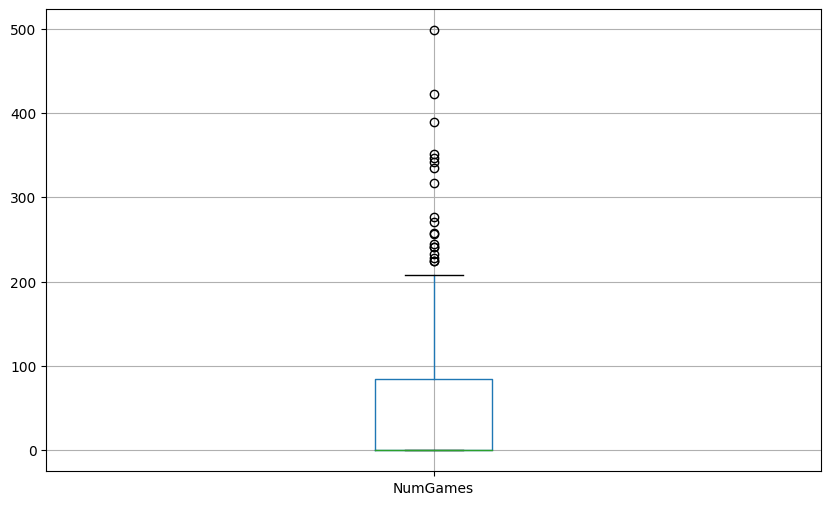

In [203]:


# type(monthly_num_games)
# plt.bar(monthly_num_games.index.tolist(), monthly_num_games.values)
# plt.xlabel('Month')
# plt.ylabel('Number of games')
# plt.show()

# daily_user_data[daily_user_data["NumGames"] != 0][["WinCount", "DrawCount", "LossCount"]].plot(kind="bar", stacked=True, figsize=(10,6))
# plt.xlabel('Date')
# plt.ylabel('Number of Games')
# plt.title('Number of Games by Result')
# plt.show()
weekly_num_games = daily_user_data[daily_user_data["NumGames"] != 0]["NumGames"].resample("W").sum()
weekly_num_games_df = pd.DataFrame({'NumGames': weekly_num_games})
weekly_num_games_df.boxplot(column='NumGames', figsize=(10,6))


In [204]:
fig = go.Figure(data =[go.Candlestick(x=daily_user_data.index,
                open =daily_user_data['open'],
                high =daily_user_data['high'],
                low  =daily_user_data['low'],
                close=daily_user_data['close'])])

fig.show()

In [205]:
(user_elo_ohlc["close"].pct_change() * 100).mean()


NameError: name 'user_elo_ohlc' is not defined

In [ ]:
#Mald index - number of resignations, number of losses, time to resign etc see if it predicts future losses
#see if time of day predicts losses/wins
#openings frequency? tree where each leaf gives W/L rate
#number of losses per day #number of games per day
#get btc data
#win more as black?
#how much elo have you gained vs taken from opponents
#Run np.where steps to check the condition only once and make all the changes when necessary.

#Literate=True in lichess API gives you notes in the PGN, evals gives you the engine rating throughout the game! accuracy=true gives, opening=, 
#get performance statistics of a user, ratings history etc is possible with the API